# Pytorch Practice


> ### AutoEncoder using Pytorch on FashionMNIST dataset

## 0. AE 모델의 설계 순서
1. module import
2. 모델 설계 시 활용하는 장비 확인
3. data set download (split tran/test set)
4. data 확인
5. AE 모델 설계
6. Optimizer, Objective Func 설정
7. train data에 대한 모델 성능 확인하는 함수 정의 (ex. accuracy, loss)
8. test data에 대한 모델의 성능 확인하는 함수 정의 (ex. accuracy, loss)
9. AE 학습 실행하며 test set의 Reconstruction error 확인

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import warnings

warnings.filterwarnings(action='ignore')

## 2. 모델 설계 시 활용하는 장비 확인 (GPU?CPU?)

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.7.0+cu101  Device: cuda:0


### 하이퍼파라미터 설정

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

## 3. Fashion MNIST Dataset Download
MNIST 데이터셋은 손글씨 숫자 이미지다. Fashion MNIST는 옷 이미지와 동일한 포맷이다. Fashion MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제다.  
train에 60000개의 이미지를 사용하고 test에 10000개의 이미지를 사용한다.

In [4]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

- fashion mnist 데이터는 이미지 데이터이다. 데이터를 다운로드할 때 transform을 사용해 기본적인 전처리를 진행한다. ToTensor()는 데이터를 tensor형태로 변경시킨다. 또한 각각의 픽셀은  [0 to 255] 사이의 스칼라 값으로 구성되어 있는데 이를 [0 to 1] 사이의 값으로 정규화 한다.  
- shuffle은 데이터의 순서를 섞고자 할 때 사용한다. 모델이 학습을 진행할 때 label 정보의 순서를 암기해 학습을 진행할 우려가 있으므로 데이터 순서를 섞어 학습한다.

## 4. 데이터 확인하기
미니배치 단위로 할당한 데이터의 개수와 형태를 확인한다.

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


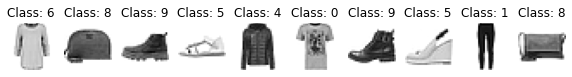

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

## 5. AutoEncoder 모델 설계
AE는 인코더와 디코더로 이루어져 있다. MLP에서와 비슷하다.
* 인코더의 첫 번째 레이어는 이미지 한 장을 입력으로 받고 512개의 node를 만든다.
* 인코더의 두 번째 레이어는 512개의 input을 받고 256개의 node를 만든다.
* 인코더의 세 번째 레이어는 256개의 input을 받고 32개의 node를 만든다.


* 디코더의 첫 번째 레이어는 32개의 input을 받고 256개의 node를 만든다.
* 디코더의 두 번째 레이어는 256개의 input을 받고 512개의 node를 만든다.
* 디코더의 세 번째 레이어는 512개의 input을 받고 784(28 * 28)개의 node를 만든다.

In [7]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

AE는 MLP와 비슷한 구조를 가진다.  
인코더와 디코더에 대해 forward propagation을 정의하는데, 먼저 이미지 데이터를 모델의 input으로 이용해 latent variable vector를 생성한다. 생성된 latent variable vector를 encoded로 저장한다. 그 후 encoded를 디코더의 input으로 사용한다.

## 6. Optimizer, Objective Function 설정
모델을 device에 할당한다. optimizer로는 주로 Adam을 사용한다. loss로는 Mean Squared Error를 사용한다.(모델의 output값과 계산될 label 값은 이미지 데이터 그 자체이므로)

In [8]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


### TIP

torchsummary 패키지를 이용하면 pytorch에서도 keras처럼 모델을 깔끔하게 출력해볼 수 있다!

In [9]:
# !pip install torchsummary

In [10]:
from torchsummary import summary

model = AE().to(DEVICE)
summary(model, input_size=(1, 784)) # input_size = (channels, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              ReLU-4               [-1, 1, 256]               0
            Linear-5                [-1, 1, 32]           8,224
            Linear-6               [-1, 1, 256]           8,448
              ReLU-7               [-1, 1, 256]               0
            Linear-8               [-1, 1, 512]         131,584
              ReLU-9               [-1, 1, 512]               0
           Linear-10               [-1, 1, 784]         402,192
Total params: 1,083,696
Trainable params: 1,083,696
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.13
Estimat

## 7. Train data에 대한 모델 성능 확인하는 함수 정의
기존에 정의한 이미지 데이터와 레이블 데이터를 이용해 AE 모델을 학습하는 함수를 정의한다.

- 모델을 학습 상태로 지정한다
- train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 mini-batch 단위로 묶여 저장되어 있다. 해당 train_loader 내의 미니배치 단위로 저장된 데이터를 순서대로 MLP 모델을 학습시킨다.  
- 레이블 데이터를 활용해 학습하는 것이 아니라 입력 데이터를 타깃으로 학습하기 때문에 레이블 데이터를 이용할 필요가 없어, 기존에 이용된 label 값을 _로 설정해 생략한다.
- 미니배치 내에 있는 데이터를 이용해 모델을 학습시키기 위해서는 모든 데이터를 DEVICE에 할당해야 한다. 
- 모델의 input은 1차원이므로 2차원인 이미지를 재구성(reshape)해야한다.
- DEVICE에 데이터를 할당할 경우, 과거에 이용한 미니 배치 내에 있는 데이터를 바탕으로 계산된 loss의 gradient 값이 optimizer에 할당되어 있으므로 optimizer의 gradient를 초기화한다.
- DEVICE에 할당한 이미지를 모델의 input으로, output을 계산한다. 계산된 output과 DEVICE의 이미지 데이터를 Mean Square Error를 이용해 loss를 계산한다.  
- loss 값을 계산한 결과를 바탕으로 backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당하고, 할당된 gradient 값을 이용해 파라미터 값을 업데이트 한다.

In [11]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Training Epoch: {}  iteration : {:5d}  Train Loss: {:.6f}".format(epoch, batch_idx * len(image), loss.item()))
        #if batch_idx % log_interval == 0:
        #    print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
        #        epoch, batch_idx * len(image), 
        #        len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
        #        loss.item()))
    print("==============================================================")

## 8. Test data에 대한 모델의 성능 확인하는 함수 정의
학습의 진행 과정을 모니터링하기 위한 함수이다.

- 모델을 평가 상태로 지정한다.
- test data를 통해 모델을 평가할 때는 gradient를 통해 파라미터 값이 업데이트 되면 안된다. 따라서 gradient의 흐름을 억제하는 코드를 작성해야 한다.
- train과 비슷함.

In [12]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    return test_loss, real_image, gen_image

## 9. MLP 학습 실행

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("---------------------------- Test ----------------------------")
    print("Test Epoch: {} Test Loss: {:.4f}".format(epoch, test_loss))
    
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()
    print("--------------------------------------------------------------")